# Train and Fine-Tune Sentence Transformers Models - Notebook Companion

In [ ]:
%%capture
!pip install sentence-transformers

## How Sentence Transformers models work


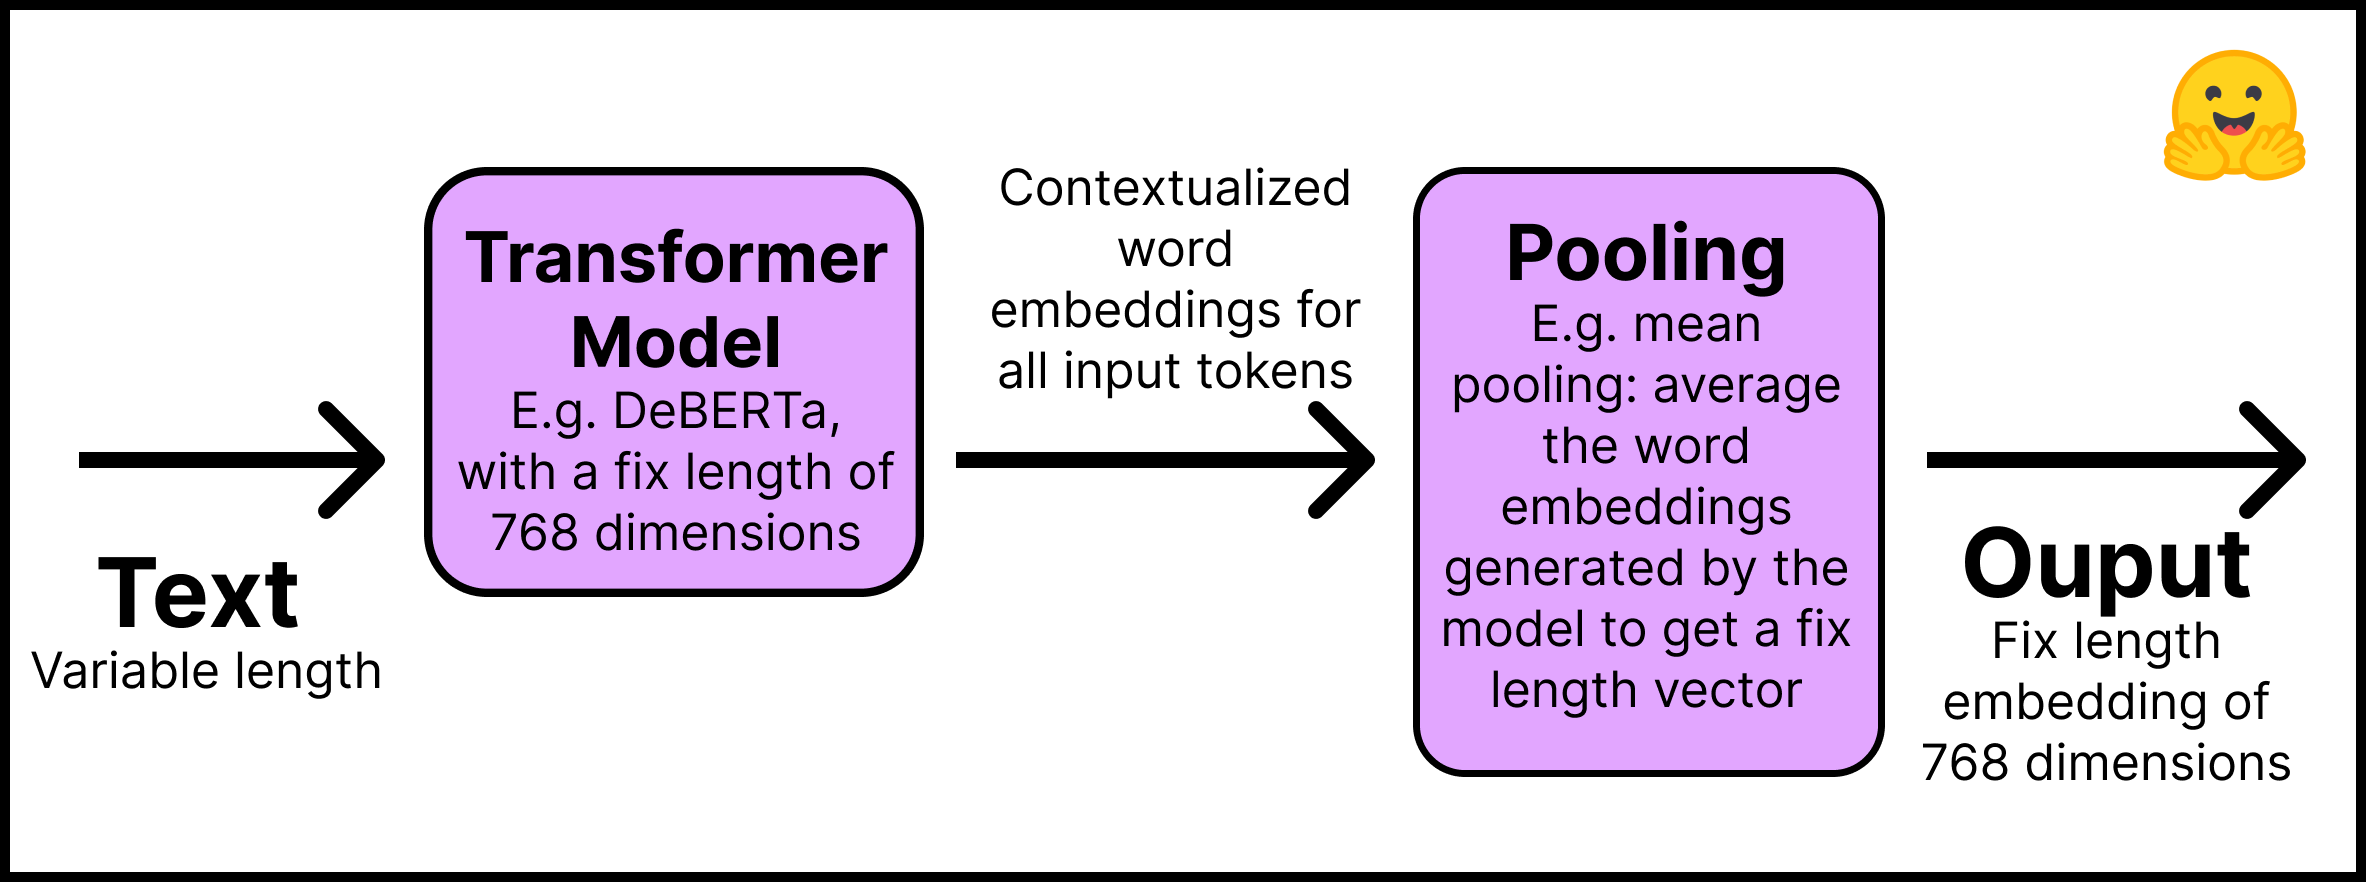

In [1]:
# See: https://huggingface.co/blog/how-to-train-sentence-transformers
from PIL import Image
from IPython.display import display
img = Image.open('training_process.png')
display(img)

In [ ]:
from sentence_transformers import SentenceTransformer, models

## Step 1: use an existing language model
word_embedding_model = models.Transformer('distilroberta-base')

## Step 2: use a pool function over the token embeddings
### MEAN POOLING:
# sum_embeddings = torch.sum(token_embeddings, dim=1)
# count = token_embeddings.shape[1]
# return (sum_embeddings / count)
### LAST TOKEN POOLING:
# return token_embeddings[:, -1]
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())

## Join steps 1 and 2 using the modules argument
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

## Types of Dataset

Text embed dataset types:
1. **Pair Distances**
2. **Paired Examples**
3. **Class Labelled**
4. **Triplets**


**Case 1** (*Pair Distances*):
- The example is a pair of sentences and a label indicating how similar they are.
- The label can be either an integer or a float. This case applies to datasets originally prepared for Natural Language Inference (NLI), since they contain pairs of sentences with a label indicating whether they infer each other or not.
- **Example:** a label indicating the degree of similarity between two sentences; for example {0,1,2} where 0 is contradiction and 2 is entailment. Review the structure of the SNLI dataset.
- **Loss Fn:** For integer, use `ContrastiveLoss` or `SoftmaxLoss`; if its a float, use `CosineSimilarityLoss`.



**Case 2** (*Paired Examples*):
- The example is a pair of positive (similar) sentences without a label.
- For example, pairs of paraphrases, pairs of full texts and their summaries, pairs of duplicate questions, pairs of (query, response), or pairs of (source_language, target_language). Natural Language Inference datasets can also be formatted this way by pairing entailing sentences. Can use `MultipleNegativesRankingLoss`, one of the most used loss functions for Sentence Transformers models.
- **Example:** The Sentence Compression dataset has examples made up of positive pairs. If your dataset has more than two positive sentences per example, for example quintets as in the COCO Captions or the Flickr30k Captions datasets, you can format the examples as to have different combinations of positive pairs.
- **Loss Fn:** Use `MultipleNegativesRankingLoss`. Can also use `MegaBatchMarginLoss` which converts to (anchor_i, positive_i, positive_j) where positive_j serves as the negative.


**Case 3** (*Class Labelled*):
- The example is a sentence with an integer label.
- This data format is easily converted by loss functions into three sentences (triplets) where the first is an "anchor", the second a "positive" of the same class as the anchor, and the third a "negative" of a different class. Each sentence has an integer label indicating the class to which it belongs.
- **Example:** The TREC dataset has integer labels indicating the class of each sentence. Each example in the Yahoo Answers Topics dataset contains three sentences and a label indicating its topic; thus, each example can be divided into three.
- **Loss Fn:** Make triplets of form [anchor, positive, negative]. Then use `BatchHardTripletLoss`, `BatchAllTripletLoss`, `BatchHardSoftMarginTripletLoss`, or `BatchSemiHardTripletLoss`.


**Case 4** (*Triplet*):
- The example is a triplet (anchor, positive, negative) without classes or labels for the sentences.
- **Example:** The Quora Triplets dataset has triplets (anchor, positive, negative) without labels.
- **Loss Fn:** use `TripletLoss`.

In [ ]:
def CosineSimilarityLoss(embedding_1, embedding_2, labelled_distance):
        y = torch.cosine_similarity(embedding_1, embedding_2)
        return mse_loss(output, labelled_distance)

In [ ]:
def MultipleNegativesRankingLoss(embeddings_a, embeddings_b)
        scores = cos_sim(embeddings_a, embeddings_b)
        labels = torch.tensor(
            range(len(scores)), dtype=torch.long, device=scores.device
        )  # Example a[i] should match with b[i]
        return cross_entropy_loss(scores, labels)


In [ ]:
  def BatchHardTripletLoss(labels: Tensor, embeddings: Tensor):
      # Get the pairwise distance matrix
      pairwise_dist = cos_sim(embeddings)

      # For each anchor, get the hardest positive
      # mask[a, p] is True iff a and p are distinct and have same label.
      indices_equal = torch.eye(labels.size(0), device=labels.device).bool()
      indices_not_equal = ~indices_equal
      labels_equal = labels.unsqueeze(0) == labels.unsqueeze(1)
      mask_anchor_positive = labels_equal & indices_not_equal

      # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
      anchor_positive_dist = mask_anchor_positive * pairwise_dist

      # shape (batch_size, 1)
      hardest_positive_dist, _ = anchor_positive_dist.max(1, keepdim=True)

      # For each anchor, get the hardest negative
      # mask[a, n] is True iff a and n have distinct labels
      mask_anchor_negative = ~(labels.unsqueeze(0) == labels.unsqueeze(1))

      # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
      max_anchor_negative_dist, _ = pairwise_dist.max(1, keepdim=True)
      anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

      # shape (batch_size,)
      hardest_negative_dist, _ = anchor_negative_dist.min(1, keepdim=True)

      # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
      tl = hardest_positive_dist - hardest_negative_dist + self.triplet_margin
      tl[tl < 0] = 0
      triplet_loss = tl.mean()

      return triplet_loss

In [ ]:
def TripletLoss(anchor, positive, negative, margin):
    loss = (anchor - positive).abs() - (anchor - negative).abs() + margin
    return max(loss, 0)

## How to prepare your dataset for training a Sentence Transformers model


In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import load_dataset

dataset_id = "embedding-data/QQP_triplets"
# dataset_id = "embedding-data/sentence-compression"

dataset = load_dataset(dataset_id)

In [ ]:
print(f"- The {dataset_id} dataset has {dataset['train'].num_rows} examples.")
print(f"- Each example is a {type(dataset['train'][0])} with a {type(dataset['train'][0]['set'])} as value.")
print(f"- Examples look like this: {dataset['train'][0]}")

- The embedding-data/QQP_triplets dataset has 101762 examples.
- Each example is a <class 'dict'> with a <class 'dict'> as value.
- Examples look like this: {'set': {'query': 'Why in India do we not have one on one political debate as in USA?', 'pos': ['Why cant we have a public debate between politicians in India like the one in US?'], 'neg': ['Can people on Quora stop India Pakistan debate? We are sick and tired seeing this everyday in bulk?', 'Why do politicians, instead of having a decent debate on issues going in and around the world, end up fighting always?', 'Can educated politicians make a difference in India?', 'What are some unusual aspects about politics and government in India?', 'What is debate?', 'Why does civic public communication and discourse seem so hollow in modern India?', 'What is a Parliamentary debate?', "Why do we always have two candidates at the U.S. presidential debate. yet the ballot has about 7 candidates? Isn't that a misrepresentation of democracy?", 'Wh

Convert the examples into `InputExample`s. It might around 10 seconds in Google Colab.

In [ ]:
from sentence_transformers import InputExample

train_examples = []
train_data = dataset['train']['set']
# For agility we only 1/2 of our available data
n_examples = dataset['train'].num_rows // 2

for i in range(n_examples):
  example = train_data[i]
  train_examples.append(InputExample(texts=[example['query'], example['pos'][0], example['neg'][0]]))

In [ ]:
print(f"We have a {type(train_examples)} of length {len(train_examples)} containing {type(train_examples[0])}'s.")

We have a <class 'list'> of length 50881 containing <class 'sentence_transformers.readers.InputExample.InputExample'>'s.


We wrap our training dataset into a Pytorch `Dataloader` to shuffle examples and get batch sizes.

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

## Loss functions for training a Sentence Transformers model


In [ ]:
from sentence_transformers import losses

train_loss = losses.TripletLoss(model=model)

## How to train a Sentence Transformer model


In [ ]:
num_epochs = 10

warmup_steps = int(len(train_dataloader) * num_epochs * 0.1) #10% of train data

Training takes around 45 minutes with a Google Colab Pro account. Decrease the number of epochs and examples if you are using a free account or no GPU.

In [ ]:
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=num_epochs,
          warmup_steps=warmup_steps)

## How to share a Sentence Transformers to the Hugging Face Hub

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

In [ ]:
model.save_to_hub(
    "distilroberta-base-sentence-transformer",
    organization="embedding-data",
    train_datasets=["embedding-data/QQP_triplets"],
    exist_ok=True,
    )

## Extra: How to fine-tune a Sentence Transformer model


Now we will fine-tune our Sentence Transformer model.

In [ ]:
modelB = SentenceTransformer('embedding-data/distilroberta-base-sentence-transformer')

In [ ]:
dataset_id = "embedding-data/sentence-compression"
datasetB = load_dataset(dataset_id)

In [ ]:
print(f"Examples look like this: {datasetB['train']['set'][0]}")

In [ ]:
train_examplesB = []
train_dataB = dataset['train']['set']
n_examples = dataset['train'].num_rows

for i in range(n_examples):
  example = train_dataB[i]
  train_examplesB.append(InputExample(texts=[example[0], example[1]]))

In [ ]:
train_dataloaderB = DataLoader(train_examplesB, shuffle=True, batch_size=64)
train_lossB = losses.MultipleNegativesRankingLoss(model=modelB)
num_epochsB = 10
warmup_stepsB = int(len(train_dataloaderB) * num_epochsB * 0.1) #10% of train data

In [ ]:
modelB.fit(train_objectives=[(train_dataloaderB, train_lossB)],
          epochs=num_epochsB,
          warmup_steps=warmup_stepsB)

In [ ]:
modelB.save_to_hub(
    "distilroberta-base-sentence-transformer",
    organization="embedding-data",
    train_datasets=["embedding-data/sentence-compression"],
    exist_ok=True,
    )